# A Pairs Trading strategy boosted with AI

This notebook explores a pairs trading strategy fueled by AI innovative techniques. This projected is being developed as part of a master thesis for the degree of Electrical and Computer Engineering.

## Table of Contents
    
    1. Searching for candidate pairs
    2. Verifying stationarity conditions
    3. Trade and monitor 

### Import Libraries

In [272]:
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt

# Import Datetime and the Pandas DataReader
from datetime import datetime
from pandas_datareader import data, wb

# Import alpha vantage
from alpha_vantage.timeseries import TimeSeries

# Import scikit instruments
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing

# just set the seed for the random number generator
np.random.seed(107)

In [24]:
ts = TimeSeries(key='MM44549W9ALMWMU0', output_format='pandas')

### Import Classes

In [4]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader
%autoreload 1

In [5]:
series_analyzer = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()

## 1. Searching for candidate pairs

The process goes as follows:

- Upload time series corresponding to ETFs
- Apply dimensionality reduction and cluster securities
- Run cointegration tests for securities within the same cluster

## 2. Verifying stationarity conditions

**Important**: Functions are coded on `class_SeriesAnalyser.py`

### Example:

For two time series `A` and `B`:

In [19]:
# Define O(1) time series
A_returns = np.random.normal(0, 1, 1000)
A = pd.Series(np.cumsum(A_returns), name='A') + 50

# Define another time series
some_noise = np.random.exponential(1, 1000)
B = A - 7 + some_noise
B = pd.Series(B, name='B')

# Let's see if the two series are cointegrated
coint_result = series_analyzer.check_for_cointegration(X=A, Y=B)

Spread: Y - b*X


A and B are cointegrated. The spread is stationary with p-value:  1.0


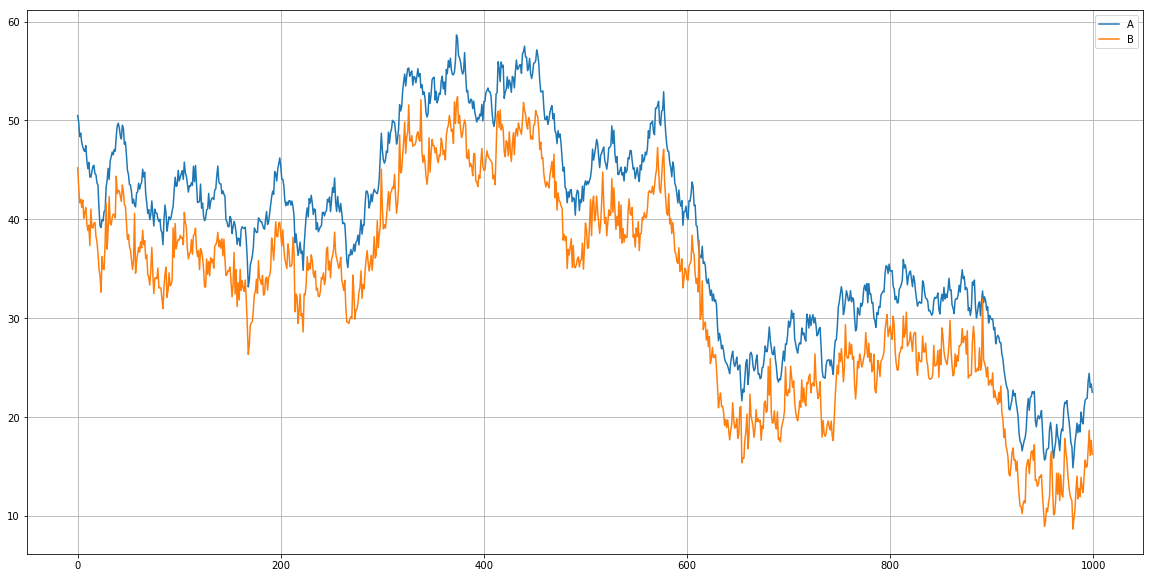

In [20]:
# evaluate results
confidence_level = 0.05
p_value = coint_result['p_value']

if p_value < confidence_level:
    print("A and B are cointegrated. The spread is stationary with p-value: ", 1-p_value)
else:
    print("A and B are not cointegrated. The spread is stationary with p-value:", 1-p_value)
    print(p_value)

pd.concat([A, B], axis=1).plot(figsize=(20, 10), use_index=True, grid=True);

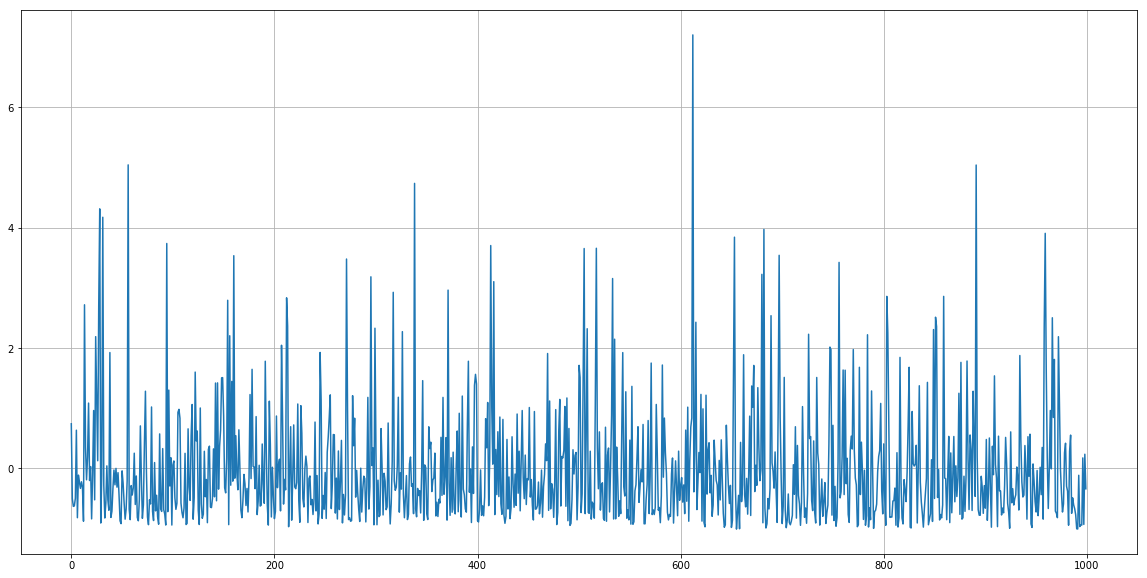

In [21]:
norm_spread = zscore(coint_result['spread'])
norm_spread.plot(figsize=(20, 10), use_index=True, grid=True)

In [22]:
coint_result.keys()

dict_keys(['t_statistic', 'critical_val', 'p_value', 'coint_coef', 'spread', 'Y', 'X'])

### Half-life

The half-life is a measurement of how long it takes for a series to mean revert. 

Ornstein-Uhlenbeck formula for mean-reverting process:

$$d y ( t ) = (\lambda y ( t - 1 ) + \mu ) d t + d \varepsilon$$

See: https://quant.stackexchange.com/questions/25086/calculating-half-life-of-mean-reverting-series-with-python

In [24]:
hf = series_analyzer.calculate_half_life(coint_result['spread'])

const   -5.653550
x1      -0.969121
dtype: float64

Estimated lambda: -0.9691209990566916
Estimated miu: -5.653549842509005
Estimated half-life: 0.7152328566140146


In [25]:
hf = series_analyzer.calculate_half_life(norm_spread)

const   -0.000753
x1      -0.969121
dtype: float64

Estimated lambda: -0.9691209990566917
Estimated miu: -0.0007526543399440301
Estimated half-life: 0.7152328566140146


### Hurst Exponent

Generalized Hurst Exponent can be used to monitor the behaviour of a time-series.

In [12]:
#  Different types of time series for testing  
#p = np.log10(np.cumsum(np.random.randn(50000)+1)+1000) # trending, hurst ~ 1  
#p = np.log10((np.random.randn(50000))+1000)   # mean reverting, hurst ~ 0  
p = np.log10(np.cumsum(np.random.randn(50000))+1000) # random walk, hurst ~ 0.5  

In [26]:
series = coint_result['spread']
print(series_analyzer.hurst(series))

-0.004127641422241569


## 3. Trade and monitor 

**Important**: Functions are coded on `class_Trader.py`

Trading is done **out-of-sample**. Having identified the candidate pairs and modelled their spreads (by defining the independent variable), we proceed to continuosly update the spread model. Updating the spread implies:
- Recalculate cointegration ratio
- Recalculate mean & variance

### Simple Strategy:
* Go "Long" the spread whenever the z-score is below -1.0
* Go "Short" the spread when the z-score is above 1.0
* Exit positions when the z-score approaches zero

### 3.1. Computing the Moving Average

- Not clear how the spread is supposed to be updated. For each new beta are we supposed to recalculate the spread? What if we just entetered a position because the updated spread was above the threshold and in the next step the update makes it go below the threshold again?

- The moving avg used to calculate the mean should be the same as the one used to calculate the spread. The one day moving average simply represents the current state of the spread.

### 3.2. Applying a Bollinger Band based strategy

Using the USO, GLD as example. The logic is that when oil prices rise, so does inflation and gold as consequence.

In [76]:
def read_pair(leg1, leg2, data_source, initial_date, final_date, close_type='Adj Close'):
    
    leg1_df = data.DataReader(leg1, data_source, initial_date, final_date)
    leg2_df = data.DataReader(leg2, data_source, initial_date, final_date)
    
    # filter columns of interest
    leg1_name = leg1 + "_close"
    leg2_name = leg2 + "_close"
    leg1_df = leg1_df[[close_type]].rename(columns={close_type: leg1_name})
    leg2_df = leg2_df[[close_type]].rename(columns={close_type: leg2_name})
    
    # concat in df
    pair_df = pd.concat([leg1_df, leg2_df], axis=1)
    
    # plot
    pair_df.plot(figsize=(20, 10), use_index=True, grid=True);
    
    return pair_df

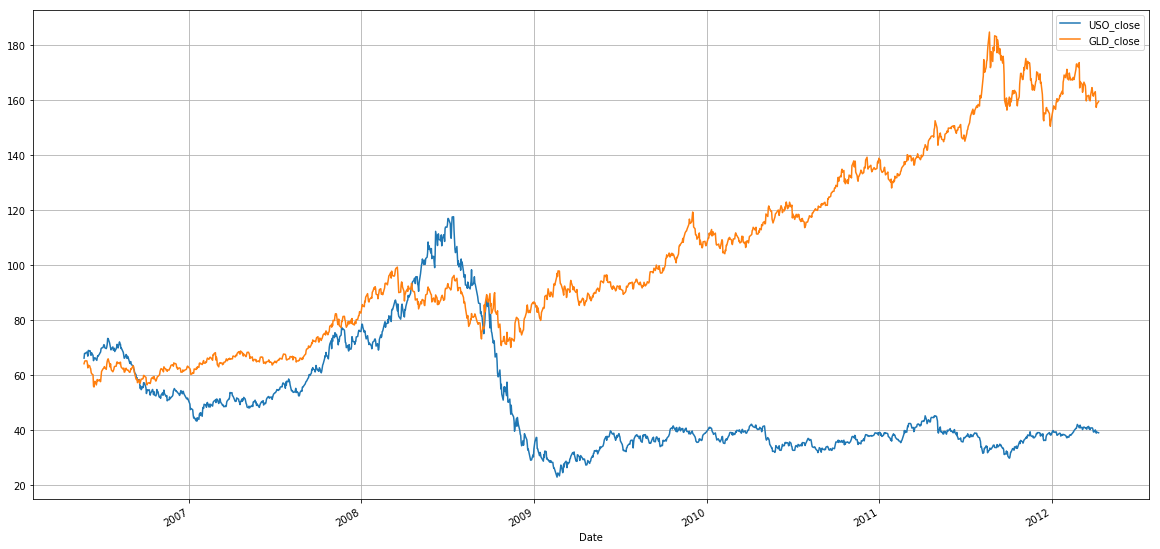

In [37]:
df_uso_gld = read_pair('USO','GLD', "yahoo", datetime(2006,5,24), datetime(2012,4,9))

In [38]:
# 1. Get best OLS regression
coint_uso_gld = series_analyzer.check_for_cointegration(X=df_uso_gld['GLD_close'], Y=df_uso_gld['USO_close'])

Spread: Y - b*X


Testing the results: On 31-07 seems a good test

In [41]:
pnl, ret, summary, _ = trader.bollinger_band_strategy(Y=coint_uso_gld['Y'], X=coint_uso_gld['X'], lookback=20)

APR 0.1871291101255479
Sharpe 1.0169519074962339


With the dataset from GitHub:

In [42]:
# double check with git version
file_path = '../external/gld_uso.csv'
df_uso_gld = pd.read_csv(file_path)
df_uso_gld = df_uso_gld[['GLD', 'USO']]

# 1. Get best OLS regression
coint_uso_gld = series_analyzer.check_for_cointegration(X=df_uso_gld['GLD'], Y=df_uso_gld['USO'])

pnl, ret, summary, _ = trader.bollinger_band_strategy(coint_uso_gld['Y'], coint_uso_gld['X'], 20)

Spread: Y - b*X
APR 0.19175226304892767
Sharpe 1.0414107351839874


In [43]:
summary.head(10)

,pnl_X,pnl_Y,pnl,ret,GLD,USO,spread,zscore,units
36,-0.000000,0.00,0.000000,0.000000,57.68,66.25,58.871310,NaN,0.0
37,0.000000,-0.00,0.000000,0.000000,56.36,65.54,56.398444,NaN,0.0
38,-0.000000,-0.00,-0.000000,0.000000,57.30,65.29,52.907888,NaN,0.0
39,-0.000000,0.00,0.000000,0.000000,58.33,66.35,51.068346,-1.033183,1.0
40,0.157192,0.65,0.807192,0.009888,57.73,67.00,50.812913,-0.968234,1.0
41,-0.072902,-0.11,-0.182902,-0.002199,57.99,66.89,49.456629,-1.050929,1.0
42,-0.087182,0.81,0.722818,0.008572,58.28,67.70,49.818158,-0.929244,1.0
43,0.184096,0.38,0.564096,0.006591,57.68,68.08,49.632915,-0.903893,1.0
44,0.044774,0.23,0.274774,0.003176,57.54,68.31,50.261840,-0.840425,1.0
45,-0.621052,1.20,0.578948,0.006704,59.52,69.51,50.393611,-0.858191,1.0


## Cumulative returns

The cumulative returns can be otained by constinuosly multiplying (1+ret).

In the end, subtract 1 and multiply by 100 to have the percentage.

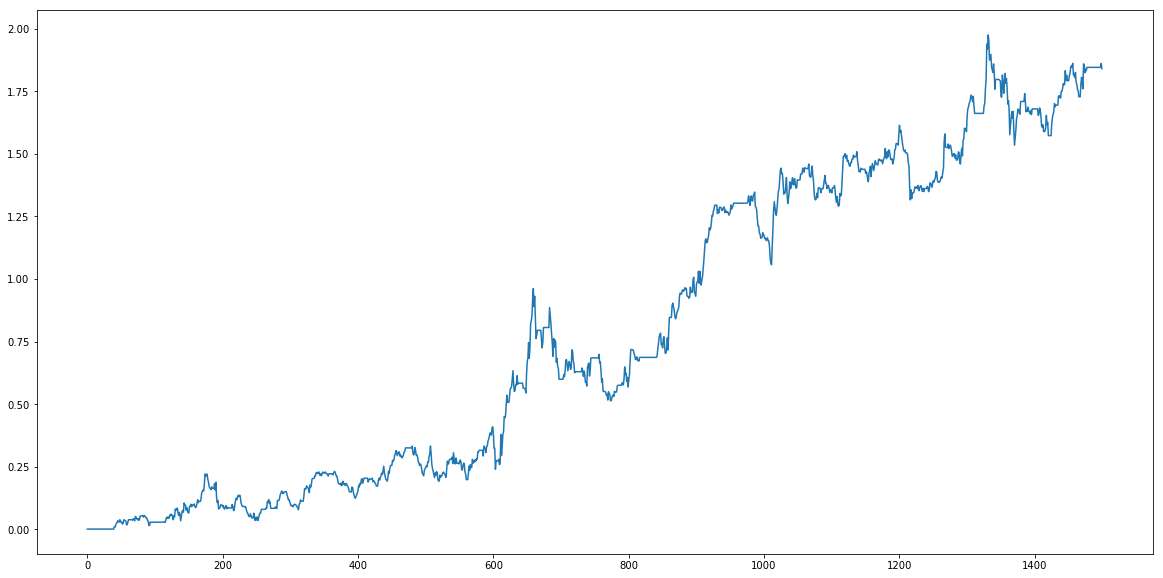

In [44]:
plt.figure(figsize=(20, 10))
plt.plot((np.cumprod(1+ret)-1))

### Summary:

- The spread acts as an indicator for the weight proportion of our bets. We should bet in Y and X with a ration $\beta$, because that's the ratio that guarantees mean reversion.

- We verify positive returns for the `GLD/USO` pair.

### 3.3. Applying the Kalman Filter

So how best to best estimate the current hedge ratio for a pair of real price series when it can vary with time? So far, we just took a moving look-back period and computed the regression coefficient over data in that period only. This has the disadvantage that if the look-back period is short, the deletion of the earliest bar and the inclusion of the latest bar as time moves forward can have an abrupt and artificial impact on the hedge ratio.We face the same problem if we use moving averages or moving standard deviations to calculate the current mean and standard deviation of a price series. 

In all cases, we may be able to improve the estimate by using a weighting scheme that *gives more weight to the latest data, and less weight to the earlier data*, without an arbitrary cutoff point. The familiar exponential moving average (EMA) is one such weighting scheme, but it is not clear why an exponential decrease in weights is optimal either. Here, we will describe a *scheme of updating the hedge ratio using the Kalman filter that avoids the problem of picking a weighting scheme arbitrarily (Montana,Triantafyllopoulos,andTsagaris,2009)*.

In [50]:
ewdf = pd.read_csv('../external/ETF.csv')
x = ewdf[['ewa']].copy()
y = ewdf[['ewc']].copy()

coint_ewa_ewc = series_analyzer.check_for_cointegration(x['ewa'], y['ewc'])

pnl, ret = trader.kalman_filter(y= coint_ewa_ewc['Y'], x=coint_ewa_ewc['X'])

Spread: Y - b*X
APR 0.262251943494046
Sharpe 2.3619490851761262


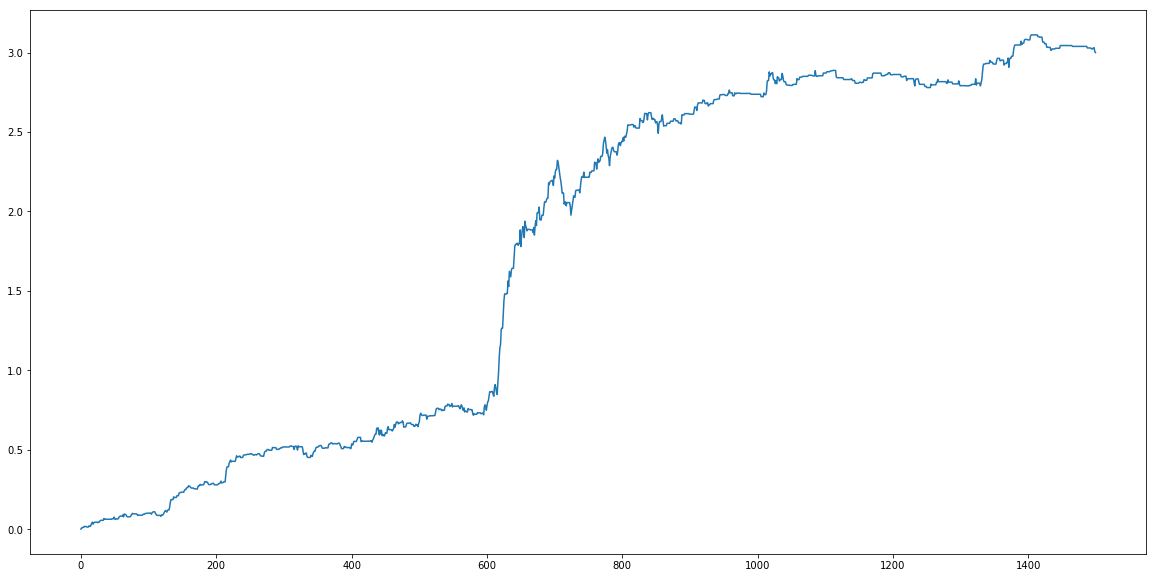

In [51]:
plt.figure(figsize=(20, 10))
plt.plot((np.cumprod(1+ret)-1))

However, when tested with USO GLD pair, the performance drops drastically...

In [63]:
# double check with git version
file_path = '../external/gld_uso.csv'
df_uso_gld = pd.read_csv(file_path)
df_uso_gld = df_uso_gld[['GLD', 'USO']]

# 1. Get best OLS regression
coint_uso_gld = series_analyzer.check_for_cointegration(X=df_uso_gld['GLD'], Y=df_uso_gld['USO'])

pnl, ret = trader.kalman_filter(y=coint_uso_gld['Y'], x=coint_uso_gld['X'])

Spread: Y - b*X
APR 0.03124938347994366
Sharpe 0.32765521601152325


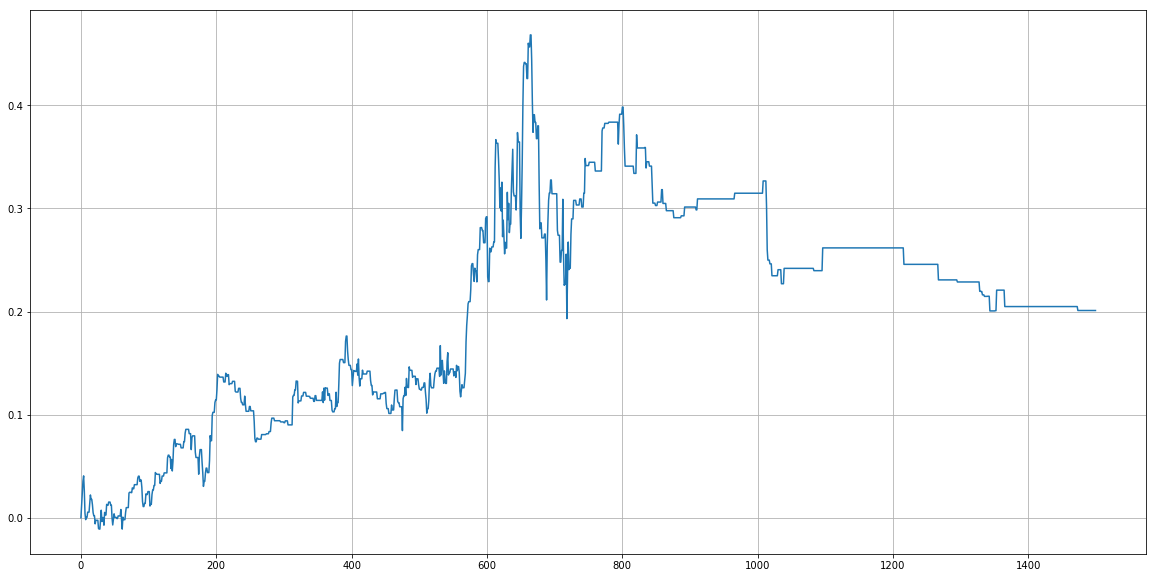

In [64]:
plt.figure(figsize=(20, 10))
plt.grid()
plt.plot((np.cumprod(1+ret)-1))

## EWA - EWC example

Following the example from Earnie Chan's book - `Algorithmic Trading`.

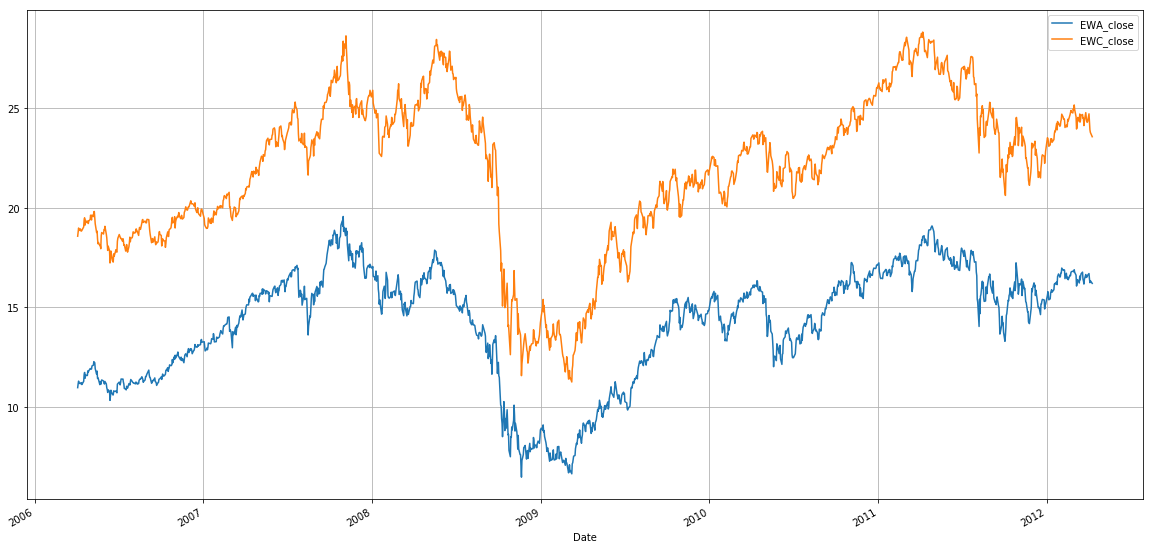

In [52]:
df_ewa_ewc = read_pair("EWA", "EWC", "yahoo",datetime(2006,4,4), datetime(2012,4,9))

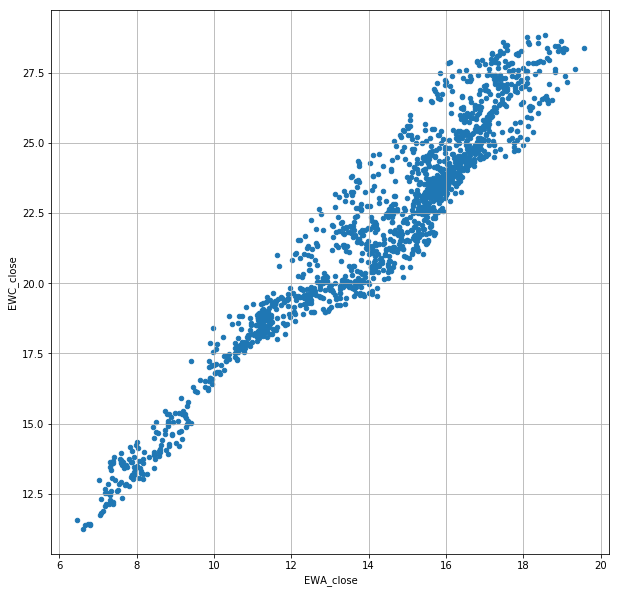

In [53]:
df_ewa_ewc.plot.scatter('EWA_close', 'EWC_close', figsize=(10, 10), use_index=True, grid=True)

**1) Cointegration:**

In [54]:
coint_ewa_ewc = series_analyzer.check_for_cointegration(df_ewa_ewc['EWA_close'], df_ewa_ewc['EWC_close'])

Spread: Y - b*X


In [55]:
coint_ewa_ewc['t_statistic']

-3.245007334719016

In [56]:
coint_ewa_ewc['critical_val']

{'1%': -3.434685171403452,
 '10%': -2.5677893640196907,
 '5%': -2.863454705264858}

In [57]:
coint_ewa_ewc['p_value']

0.017522882085845137

**2) Half life mean-reversion**

In [58]:
hl = series_analyzer.calculate_half_life(coint_ewa_ewc['spread'])

const    0.086602
x1      -0.024212
dtype: float64

Estimated lambda: -0.02421217752082206
Estimated miu: 0.08660213036868612
Estimated half-life: 28.628039752469622


**3) Hurst Exponent**

In [59]:
series_analyzer.hurst(coint_ewa_ewc['spread'])

0.41284535452684673

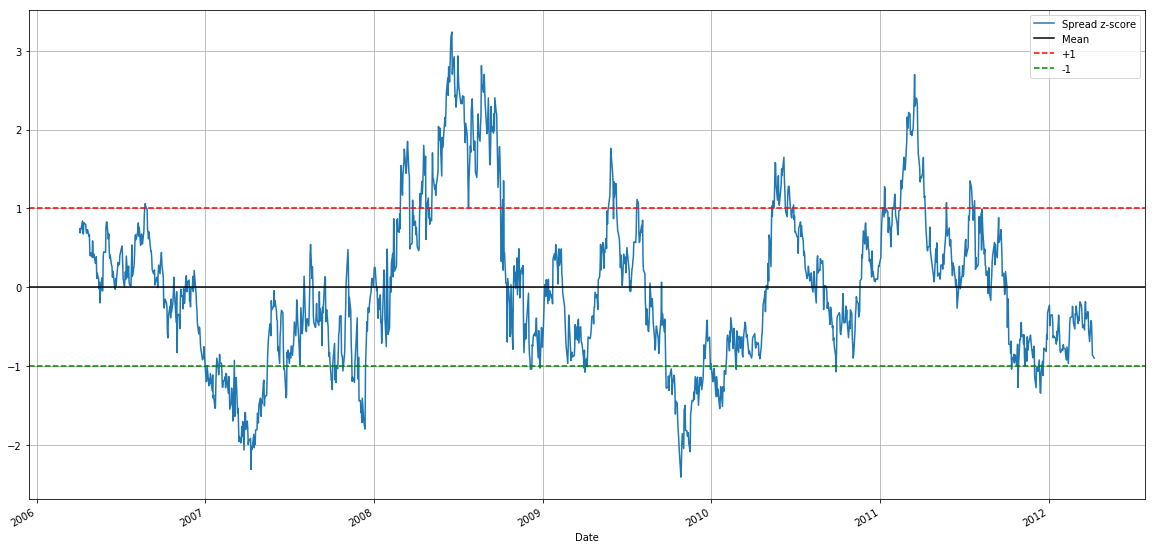

In [60]:
spread = coint_ewa_ewc['spread']
zscore(spread).plot(figsize=(20, 10), use_index=True, grid=True)
plt.axhline(series_analyzer.zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

**4) Trading:**

In [61]:
pnl, ret, summary, _ = trader.bollinger_band_strategy(Y=coint_ewa_ewc['Y'], X=coint_ewa_ewc['X'], lookback=int(round(hl)))

APR 0.00830283640942664
Sharpe 0.1316874742439809


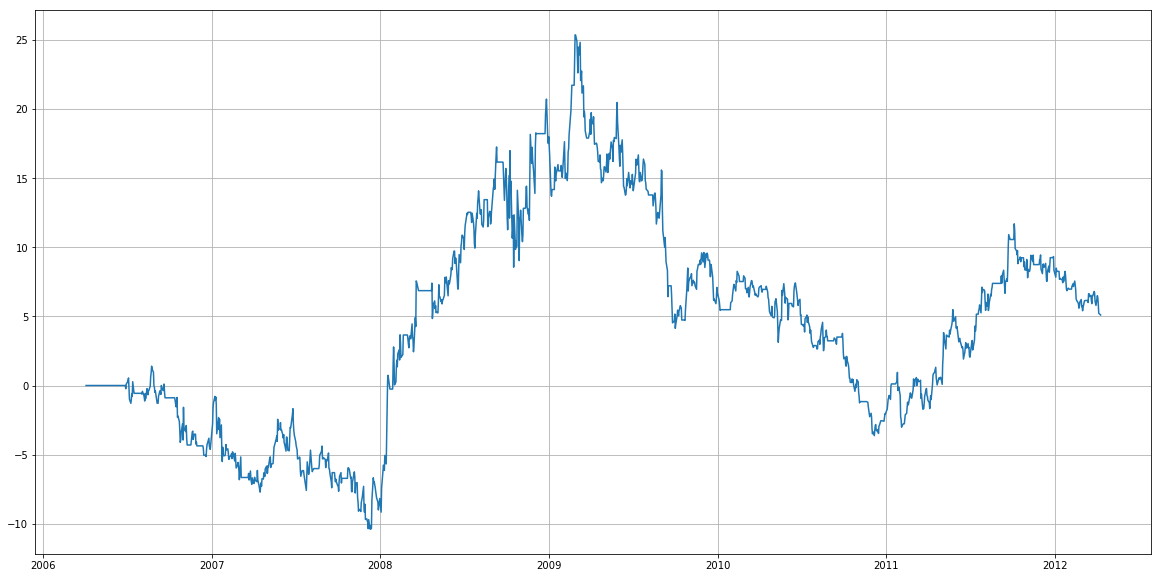

In [62]:
plt.figure(figsize=(20, 10))
plt.grid()
plt.plot((np.cumprod(1+ret)-1) * 100)

# USD.CAD Example

Taken from Earnie Chan's book

In [65]:
usd_cad = data.DataReader("DEXCAUS", "fred", datetime(2007,7,22), datetime(2012,3,28))

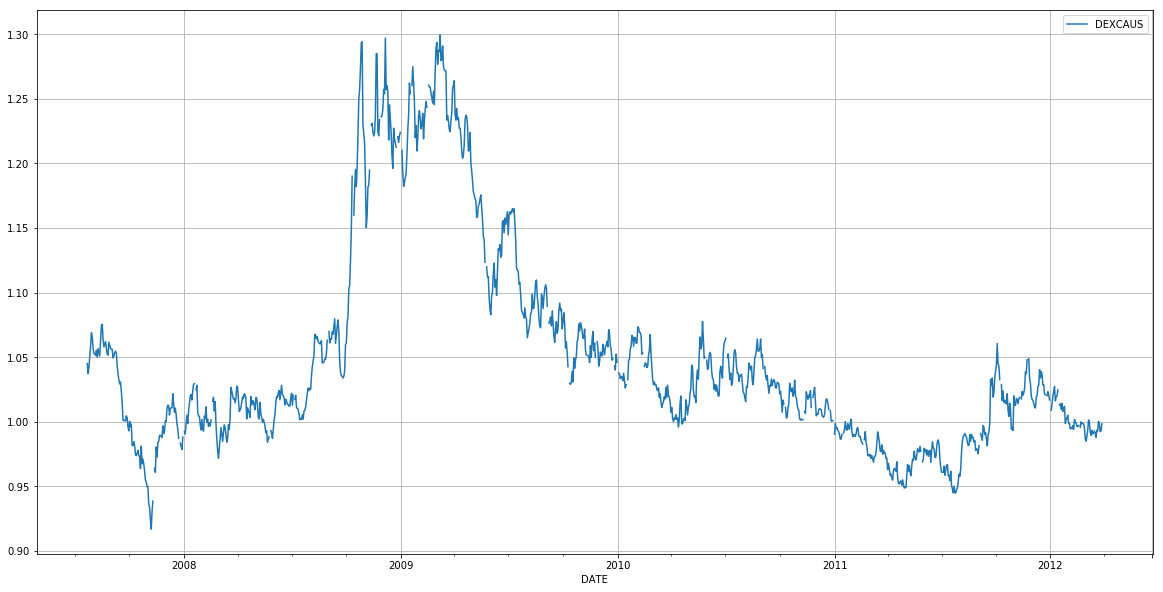

In [66]:
usd_cad.plot(figsize=(20, 10), use_index=True, grid=True)

In [67]:
usd_cad = usd_cad.dropna()
series_analyzer.check_for_stationarity(usd_cad['DEXCAUS'])

{'critical_values': {'1%': -3.435913333460925,
  '10%': -2.5680779665111078,
  '5%': -2.863996640985854},
 'p_value': 0.3413930952998334,
 't_statistic': -1.8802821581512863}

In [68]:
series_analyzer.hurst(np.log(usd_cad['DEXCAUS']))

0.45656233485210285

In [69]:
series_analyzer.calculate_half_life(usd_cad['DEXCAUS'])

const    0.006424
x1      -0.006161
dtype: float64

Estimated lambda: -0.0061607274401545686
Estimated miu: 0.006423786978678875
Estimated half-life: 112.51060646542004


112.51060646542004

## Hurst Exponent for Google

In [70]:
# Download the Google OHLCV data from 1/1/2000 to 1/1/2013
goog = data.DataReader("GOOG", "yahoo", datetime(2000,1,1), datetime(2013,1,1))

# Output the results of the Augmented Dickey-Fuller test for Google
# with a lag order value of 1
adfuller(goog['Adj Close'], 1)

(-2.1900105614322416,
 0.20989100364912439,
 0,
 2106,
 {'1%': -3.4334588739173006,
  '10%': -2.5675011176676956,
  '5%': -2.8629133710702983},
 12491.428049789843)

In [72]:
# Assuming you have run the above code to obtain 'goog'!
print("Hurst(GOOG):  %s" % series_analyzer.hurst(goog['Adj Close']))

Hurst(GOOG):  0.5078801187952492


# Commodity ETFs Dataset

In this section, we proceed to analyze ETFs from different commodity sectors and detect possible interesting pairs.

In [201]:
etfs = pd.read_excel('data/etfs/commodity_ETFs.xlsx')

In [202]:
duplicated_etfs = etfs[etfs.duplicated(subset=['Ticker'], keep=False)].sort_values(['Ticker'])
duplicated_etfs

,Sector,Ticker,Description,Issuer,AUM,ExpenseRatio,3-MO TR,Segment
59,Commodity,AAAU,Perth Mint Physical Gold ETF,Exchange Traded Concepts,$108.72M,0.18%,4.10%,Commodities: Precious Metals Gold
339,Precious Metals,AAAU,Perth Mint Physical Gold ETF,Exchange Traded Concepts,$108.72M,0.18%,4.10%,Commodities: Precious Metals Gold
232,Gold,AAAU,Perth Mint Physical Gold ETF,Exchange Traded Concepts,$108.72M,0.18%,4.10%,Commodities: Precious Metals Gold
137,Commodity,AGF,DB Agriculture Long ETN,Deutsche Bank,$716.83K,0.75%,NaN,Commodities: Agriculture
17,Agriculture,AGF,DB Agriculture Long ETN,Deutsche Bank,$716.83K,0.75%,NaN,Commodities: Agriculture
48,Commodity,AGQ,ProShares Ultra Silver,ProShares,$183.61M,5.28%,7.49%,Leveraged Commodities: Precious Metals Silver
362,Silver,AGQ,ProShares Ultra Silver,ProShares,$183.61M,5.28%,7.49%,Leveraged Commodities: Precious Metals Silver
334,Precious Metals,AGQ,ProShares Ultra Silver,ProShares,$183.61M,5.28%,7.49%,Leveraged Commodities: Precious Metals Silver
102,Commodity,BAL,iPath Series B Bloomberg Cotton Subindex Total...,Barclays Bank PLC,$8.84M,0.45%,5.30%,Commodities: Agriculture Cotton
152,Cotton,BAL,iPath Series B Bloomberg Cotton Subindex Total...,Barclays Bank PLC,$8.84M,0.45%,5.30%,Commodities: Agriculture Cotton


Remove duplicates

In [265]:
etfs_unique = etfs[~etfs.duplicated(subset=['Ticker'], keep='first')].sort_values(['Ticker'])

In [264]:
tickers = etfs_unique.Ticker.unique()

In [273]:
initial_date = '01-06-2017'
final_date = '01-01-2018'
data_source = 'yahoo'
dataset = {key: None for key in tickers}
for ticker in tickers:
    try:
        df = data.DataReader(ticker, data_source, initial_date, final_date)
        df = df[['Adj Close']].rename(columns={'Adj Close':ticker}) # filter close price only
        dataset[ticker] = df.copy()
    except:
        print('Not Possible to retrieve information for '+ticker)

Not Possible to retrieve information for AAAU
Not Possible to retrieve information for AOIL
Not Possible to retrieve information for BATT
Not Possible to retrieve information for CMDY
Not Possible to retrieve information for GLDM
Not Possible to retrieve information for IAUF
Not Possible to retrieve information for PLTM
Not Possible to retrieve information for PYPE
Not Possible to retrieve information for SDCI
Not Possible to retrieve information for XLEY


In [280]:
print('Unable to download ' + str(10/len(tickers)*100) + '% of the ETFs')
print('From now on, we are only considering ' + str(len(tickers)-10) + ' ETFs')

Unable to download 4.6082949308755765% of the ETFs
From now on, we are only considering 207 ETFs


In [110]:
data_alpha, meta_data = ts.get_daily(symbol='TBLU', outputsize='full')

In [111]:
data_alpha.head(1)

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2017-02-15,25.02,25.159,25.02,25.145,3306.0


Further analyzing the tickers that were not possible to obtain, we cocnlude that many of the considered ETFs are fairly recent and were not available the the initial date defined previously.

## PCA on returns

A purely fundamental approach is a one way to search for pairs, however breadth will likely be low. Sharpe can be maximized by having high breadth (high number of bets). With N stocks in the universe, there are N*(N-1)/2 pair-wise relationships. However, if we do a brute-force search over these, we will likely end up with many spurious results due to comparison bias. As such, we narrow down the search space in a reasonable way, assuming ETFs that share loadings to common factors (defined below) in the past should be related in the future.

In [275]:
first_count = True
for k in dataset.keys():
    if dataset[k] is not None:
        if first_count:
            etfs_pricing = dataset[k]
            first_count = False
        else:
            etfs_pricing = pd.concat([etfs_pricing, dataset[k]], axis=1)
            
print(etfs_pricing.shape)

(248, 207)


**Remove ETFs without sufficient information**

In [284]:
null_values = etfs_pricing.isnull().sum()
null_values = null_values[null_values > 0]
null_values

BAR     165
BCD      58
BCI      58
BMLP      9
COMB    124
COMG     96
GLDW     17
GOAU    120
OILD     54
OILU     54
PPLN    180
TBLU     27
USAI    236
USOD    128
USOI    117
USOU    128
dtype: int64

In [114]:
threshold = 0
to_remove = list(null_values[null_values>threshold].index)
etfs_pricing = etfs_pricing.drop(columns=to_remove)
print(etfs_pricing.shape)

(248, 190)


In [286]:
etfs_returns = etfs_pricing.pct_change()
etfs_returns = etfs_returns.iloc[1:]
etfs_returns.head()

,AGF,AGQ,AMJ,AMJL,AMLP,AMU,AMUB,AMZA,ATMP,BAL,...,WTID,WTIU,XES,XLE,XME,XOP,YMLI,YMLP,ZMLP,ZSL
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-09,0.000855,0.010483,-0.010510,0.028561,-0.005464,-0.010340,0.0,-0.009083,-0.012018,-0.016175,...,0.082231,-0.101370,-0.015177,-0.014495,-0.013522,-0.028011,-0.014259,-0.010097,-0.011801,-0.011373
2017-01-10,0.000000,0.027666,-0.014683,-0.023801,-0.008634,-0.014428,0.0,-0.009166,-0.017198,0.002497,...,0.086292,-0.041376,-0.012843,-0.009092,0.035384,0.000000,-0.013836,-0.000756,-0.009346,-0.025814
2017-01-11,0.000000,-0.007011,0.011097,0.000074,0.008709,0.014134,0.0,0.006938,0.010670,0.000623,...,-0.101933,0.054521,0.022550,0.010795,0.003079,0.009852,0.017219,0.012476,0.014675,0.006336
2017-01-12,0.000000,0.004518,-0.004390,0.000000,-0.003140,-0.005973,0.0,-0.001378,-0.003378,-0.011826,...,0.000000,0.048686,-0.010602,-0.004138,-0.013505,-0.006829,-0.003135,-0.001120,-0.004132,-0.005152
2017-01-13,0.000000,0.003374,0.005669,0.000000,0.003937,0.005508,0.0,0.000920,0.002119,-0.000420,...,0.015656,-0.032046,-0.013716,-0.002949,0.008712,-0.006139,0.005031,0.004860,0.005187,-0.002877


In [288]:
print('Total number of possible pairs: ', len(etfs_returns.columns)*(len(etfs_returns.columns)-1)/2)

Total number of possible pairs:  18145.0


**Applying PCA on Returns**

In [289]:
N_PRIN_COMPONENTS = 50
pca = PCA(n_components=N_PRIN_COMPONENTS)
pca.fit(etfs_returns)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [290]:
pca.components_.T.shape

(191, 50)

We have reduced data now with the first `N_PRIN_COMPONENTS` principal component loadings. 

In [291]:
X = preprocessing.StandardScaler().fit_transform(pca.components_.T)
print(X.shape)

(191, 50)


**Clustering**

We will make use of the DBSCAN unsupervised clustering algorithm, which is available in scikit-learn. DBSCAN has advantages in this use case, specifically:

- DBSCAN does not cluster all stocks; it leaves out stocks which do not neatly fit into a cluster;
- No need to specify the number of clusters.

The clustering algorithm will give us sensible candidate pairs. We will need to do some validation in the next step.

In [301]:
clf = DBSCAN(eps=2, min_samples=2)
print(clf)

clf.fit(X)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("\nClusters discovered: %d" % n_clusters_)

clustered = clf.labels_

DBSCAN(algorithm='auto', eps=2, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=2, n_jobs=1, p=None)

Clusters discovered: 9


In [302]:
clustered_series = pd.Series(index=etfs_returns.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

In [303]:
counts = clustered_series.value_counts()
print("Clusters formed: %d" % len(counts))
print("Pairs to evaluate: %d" % (counts*(counts-1)/2).sum())

Clusters formed: 9
Pairs to evaluate: 360


In [304]:
print(counts)

1    18
6    14
0    12
4     9
5     4
7     3
2     3
8     2
3     2
dtype: int64


**Fundamental analysis for clusters**

In [305]:
for label_n in range(len(counts)):
    elements_cluster_n = list(clustered_series[clustered_series == label_n].index)
    etfs_cluster_n = etfs_unique[etfs_unique['Ticker'].isin(elements_cluster_n)]
    print('\nCluster {}:\n{}'.format(label_n, etfs_cluster_n[['Ticker', 'Segment']]))
    #print('\nCluster {}:\n{}'.format(label_n,etfs_cluster_n.Segment.value_counts()))


Cluster 0:
    Ticker            Segment
156    AMJ  Equity: U.S. MLPs
154   AMLP  Equity: U.S. MLPs
170    AMU  Equity: U.S. MLPs
166   AMZA  Equity: U.S. MLPs
157   EMLP  Equity: U.S. MLPs
181   ENFR  Equity: U.S. MLPs
161   MLPA  Equity: U.S. MLPs
159   MLPI  Equity: U.S. MLPs
164   MLPX  Equity: U.S. MLPs
169   TPYP  Equity: U.S. MLPs
200   YMLI  Equity: U.S. MLPs
184   ZMLP  Equity: U.S. MLPs

Cluster 1:
    Ticker                                  Segment
72     BCM                Commodities: Broad Market
62     BNO            Commodities: Energy Crude Oil
28     DBC                Commodities: Broad Market
61     DBE                      Commodities: Energy
43     DBO            Commodities: Energy Crude Oil
78    DJCI                Commodities: Broad Market
32     DJP                Commodities: Broad Market
50    FTGC                Commodities: Broad Market
53     GCC                Commodities: Broad Market
30     GSG                Commodities: Broad Market
79     GSP    

Comparing results obtaned with most obvious scenario:

In [306]:
grouped = etfs_unique.groupby(by='Segment').count()[['Ticker']]
grouped[grouped.Ticker > 1]

,Ticker
Segment,
Commodities: Agriculture,7
Commodities: Agriculture Grains,3
Commodities: Agriculture Sugar,2
Commodities: Broad Market,21
Commodities: Energy,4
Commodities: Energy Crude Oil,10
Commodities: Energy Natural Gas,3
Commodities: Industrial Metals,2
Commodities: Industrial Metals Copper,2


What can we conclude??
- First of all, the securities in each cluster are indeed from segments tham seem to be fundamentally related.
- Moreover, we see that some filtering is being performed, and the clustering goes further than a simple groupby segment would.

Let's proceed to plot the identified time series.

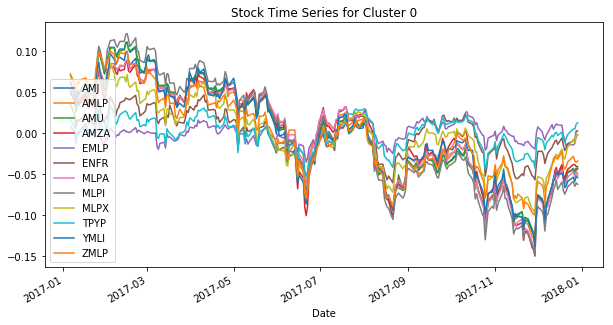

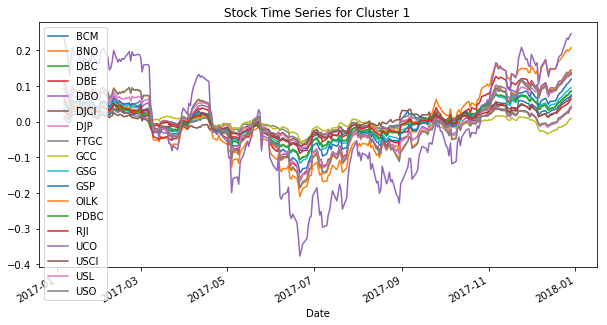

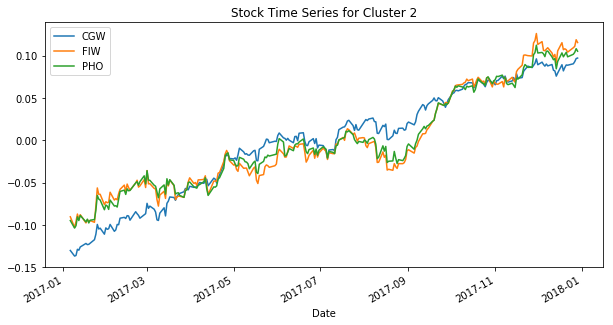

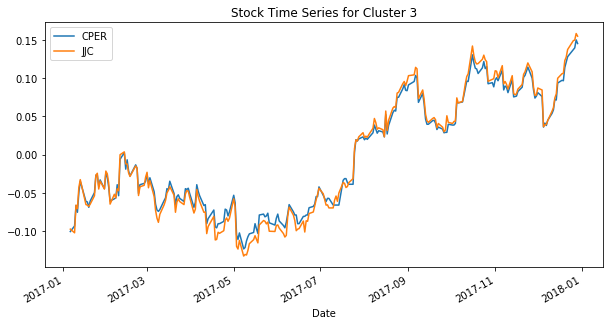

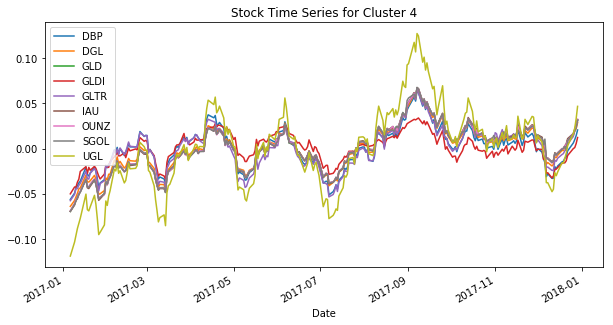

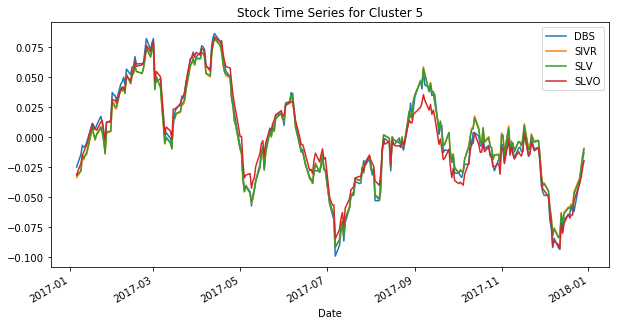

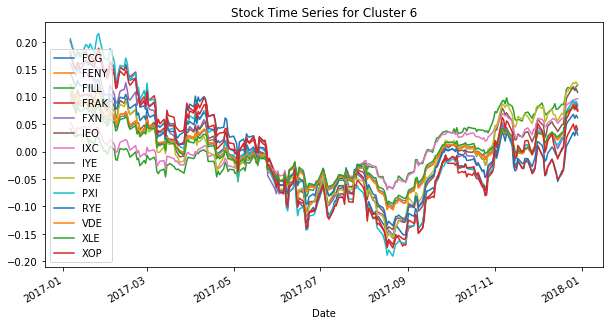

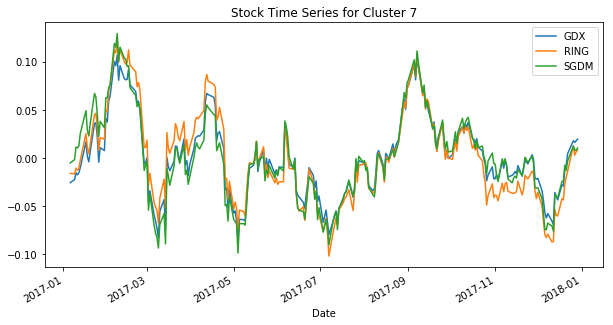

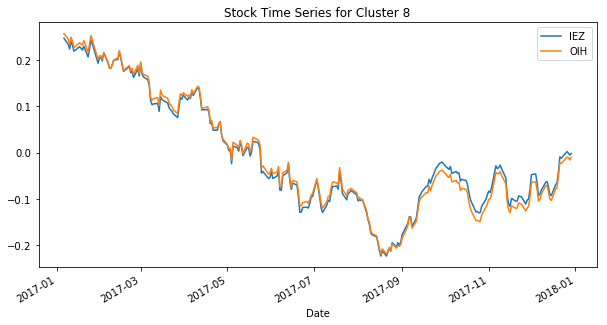

In [307]:
for clust in range(len(counts)):
    symbols = list(clustered_series[clustered_series==clust].index)
    means = np.log(etfs_pricing[symbols].mean())
    series = np.log(etfs_pricing[symbols]).sub(means)
    series.plot(title='Stock Time Series for Cluster %d' % clust, figsize=(10,5))

We now investigate whether it is possible to find cointegrated pairs within the clusters

In [318]:
clusters_pairs = []
threshold = 0.20
pairs_found = 0
for clust in range(len(counts)):
    symbols = list(clustered_series[clustered_series==clust].index)
    cluster_pricing = etfs_pricing[symbols]
    _, _, pairs = series_analyzer.find_cointegrated_pairs(cluster_pricing, threshold)
    clusters_pairs.append(pairs)
    print('\nCluster {}: {}'.format(clust,pairs))
    pairs_found += len(pairs)
print('Found {} pairs'.format(pairs_found))


Cluster 0: [('AMJ', 'AMZA', 0.04975475307247361), ('AMLP', 'AMZA', 0.06126206255670011), ('AMU', 'AMZA', 0.0492898350375233), ('AMZA', 'MLPA', 0.13335859564398506), ('AMZA', 'MLPI', 0.031194285662188365), ('AMZA', 'ZMLP', 0.18521670528708128), ('EMLP', 'MLPA', 0.1136811214850687), ('EMLP', 'MLPI', 0.09349151474848294), ('EMLP', 'YMLI', 0.14166760294914738), ('EMLP', 'ZMLP', 0.12593971536094772), ('ENFR', 'MLPX', 0.16561882508314618), ('ENFR', 'ZMLP', 0.12835123188114267), ('MLPX', 'ZMLP', 0.1893357761881344), ('TPYP', 'YMLI', 0.12510104024617702), ('TPYP', 'ZMLP', 0.08692846143424937), ('YMLI', 'ZMLP', 0.18007919186388804)]

Cluster 1: [('BCM', 'USCI', 0.16592625222703627), ('BNO', 'DBE', 0.13004088371845057), ('DBC', 'PDBC', 0.15373591616735577), ('DJCI', 'DJP', 2.9060369487740996e-06), ('FTGC', 'GSG', 0.09664501555408789), ('FTGC', 'GSP', 0.07475512860275181), ('FTGC', 'OILK', 0.07451327073531633), ('FTGC', 'PDBC', 0.15844413760713588), ('FTGC', 'RJI', 0.022362271734713883), ('FTGC'

In [436]:
clusters_pairs = []
threshold = 0.20
pairs_found = 0
for clust in range(len(counts)):
    symbols = list(clustered_series[clustered_series==clust].index)
    cluster_pricing = etfs_pricing[symbols]
    pairs = series_analyzer.find_cointegrated_pairs(cluster_pricing, threshold)
    clusters_pairs.append(pairs)
    print('\nCluster {}: {}'.format(clust,[(pair[0], pair[1], pair[2]['p_value']) for pair in pairs]))
    pairs_found += len(pairs)
print('Found {} pairs'.format(pairs_found))

p value personalized1 : 0.13544753832758305 :: p value coint : 0.5526897266387986 :: p value coint2 0.5526897266387986
p value personalized1 : 0.0030842147459517934 :: p value coint : 0.35920143503201907 :: p value coint2 0.35920143503201907
p value personalized1 : 0.03499285323280881 :: p value coint : 0.04975475307247361 :: p value coint2 0.04975475307247361
p value personalized1 : 0.0009626297825452909 :: p value coint : 0.826305477996734 :: p value coint2 0.826305477996734
p value personalized1 : 0.024511341847389935 :: p value coint : 0.7338643479620108 :: p value coint2 0.7338643479620108
p value personalized1 : 0.24618084806117269 :: p value coint : 0.6470675574679033 :: p value coint2 0.6470675574679033
p value personalized1 : 0.20033590337942203 :: p value coint : 0.49595291164969785 :: p value coint2 0.49595291164969785
p value personalized1 : 0.024938814258721374 :: p value coint : 0.6350395010349217 :: p value coint2 0.6350395010349217
p value personalized1 : 0.003396682619

p value personalized1 : 0.034028922205390576 :: p value coint : 0.459122409051584 :: p value coint2 0.459122409051584
p value personalized1 : 0.023646911725298248 :: p value coint : 0.44885113201775273 :: p value coint2 0.44885113201775273
p value personalized1 : 0.05046566553815773 :: p value coint : 0.6099345078981472 :: p value coint2 0.6099345078981472
p value personalized1 : 0.3143125323095852 :: p value coint : 0.9862083722334956 :: p value coint2 0.9862083722334956
p value personalized1 : 0.3760353458004021 :: p value coint : 0.9871167918058747 :: p value coint2 0.9871167918058747
p value personalized1 : 0.12845318069116685 :: p value coint : 0.8333210851519278 :: p value coint2 0.8333210851519278
p value personalized1 : 0.24679294848382272 :: p value coint : 0.9915107463013492 :: p value coint2 0.9915107463013492
p value personalized1 : 0.08393518279759254 :: p value coint : 0.5961025258861758 :: p value coint2 0.5961025258861758
p value personalized1 : 0.08004205595412173 :: p

p value personalized1 : 0.09291019994242705 :: p value coint : 0.6043714597734575 :: p value coint2 0.6043714597734575
p value personalized1 : 0.6071043552043429 :: p value coint : 0.9722993478153633 :: p value coint2 0.9722993478153633
p value personalized1 : 0.12742664776073603 :: p value coint : 0.7402829676661088 :: p value coint2 0.7402829676661088
p value personalized1 : 0.19416957692144565 :: p value coint : 0.953916222711619 :: p value coint2 0.953916222711619
p value personalized1 : 0.34992043296367176 :: p value coint : 0.8850871099729481 :: p value coint2 0.8850871099729481
p value personalized1 : 1.3366639763764123e-07 :: p value coint : 2.9060369487740996e-06 :: p value coint2 2.9060369487740996e-06
p value personalized1 : 0.0013226000046019893 :: p value coint : 0.2800825470815353 :: p value coint2 0.2800825470815353
p value personalized1 : 0.6117924558321087 :: p value coint : 0.9789278342424241 :: p value coint2 0.9789278342424241
p value personalized1 : 0.2404400968391

p value personalized1 : 0.18120269245590992 :: p value coint : 0.6999973872283853 :: p value coint2 0.6999973872283853
p value personalized1 : 0.051102569942107 :: p value coint : 0.6232905676785723 :: p value coint2 0.6232905676785723
p value personalized1 : 0.33760232226533143 :: p value coint : 0.7182769973226784 :: p value coint2 0.7182769973226784
p value personalized1 : 0.027572854348804254 :: p value coint : 0.41802018882942527 :: p value coint2 0.41802018882942527
p value personalized1 : 0.04274674165670322 :: p value coint : 0.4191225737714158 :: p value coint2 0.4191225737714158
p value personalized1 : 0.1515217135105706 :: p value coint : 0.7152873814383862 :: p value coint2 0.7152873814383862
p value personalized1 : 0.4184915652394442 :: p value coint : 0.8328090119944922 :: p value coint2 0.8328090119944922
p value personalized1 : 0.31341906954851845 :: p value coint : 0.7693875555266774 :: p value coint2 0.7693875555266774
p value personalized1 : 0.1933916612145053 :: p v

p value personalized1 : 5.799691937639706e-06 :: p value coint : 0.004614605412251508 :: p value coint2 0.004614605412251508
p value personalized1 : 0.3862119002283353 :: p value coint : 0.8828722450364008 :: p value coint2 0.8828722450364008
p value personalized1 : 0.2719036086319071 :: p value coint : 0.8944252704136053 :: p value coint2 0.8944252704136053

Cluster 4: [('DBP', 'GLD', 0.17820883560176187), ('DBP', 'GLDI', 0.12436927641782225), ('DBP', 'IAU', 0.17190487760260298), ('DBP', 'OUNZ', 0.1973684584738699), ('DGL', 'GLTR', 0.14813741633938216), ('GLD', 'GLDI', 0.09826584209857697), ('GLD', 'GLTR', 0.16757123262179902), ('GLDI', 'IAU', 0.09550915627947104), ('GLDI', 'OUNZ', 0.09856661557211222), ('GLDI', 'SGOL', 0.09423839177724858), ('GLDI', 'UGL', 0.1653332394115674), ('GLTR', 'IAU', 0.13840774252859772), ('GLTR', 'OUNZ', 0.14859377103800014), ('GLTR', 'SGOL', 0.14978446733000567)]
p value personalized1 : 0.008558290645581083 :: p value coint : 0.49703328964068505 :: p value

p value personalized1 : 0.3244705916169196 :: p value coint : 0.9813470281781334 :: p value coint2 0.9813470281781334
p value personalized1 : 0.5024957824755416 :: p value coint : 0.8935296140192392 :: p value coint2 0.8935296140192392
p value personalized1 : 0.4978431444631556 :: p value coint : 0.989682684345297 :: p value coint2 0.989682684345297
p value personalized1 : 0.3331467898898673 :: p value coint : 0.9918340214358197 :: p value coint2 0.9918340214358197
p value personalized1 : 0.3137008190994568 :: p value coint : 0.9855043881852461 :: p value coint2 0.9855043881852461
p value personalized1 : 0.3132210871948124 :: p value coint : 0.960174107492032 :: p value coint2 0.960174107492032
p value personalized1 : 0.5050838349274291 :: p value coint : 0.9904196829769729 :: p value coint2 0.9904196829769729
p value personalized1 : 0.10903367420390175 :: p value coint : 0.4553141862072715 :: p value coint2 0.4553141862072715
p value personalized1 : 0.7149539520316646 :: p value coint

In [430]:
clusters_pairs = []
threshold = 0.20
pairs_found = 0
for clust in range(len(counts)):
    symbols = list(clustered_series[clustered_series==clust].index)
    cluster_pricing = etfs_pricing[symbols]
    pairs = series_analyzer.find_cointegrated_pairs(cluster_pricing, threshold)
    clusters_pairs.append(pairs)
    print('\nCluster {}: {}'.format(clust,[(pair[0], pair[1], pair[2]['p_value']) for pair in pairs]))
    pairs_found += len(pairs)
print('Found {} pairs'.format(pairs_found))


Cluster 0: [('AMJ', 'AMLP', 0.13544753832758305), ('AMJ', 'AMZA', 0.03499285323280881), ('AMJ', 'EMLP', 0.0009626297825452909), ('AMJ', 'ENFR', 0.024511341847389935), ('AMJ', 'MLPX', 0.024938814258721374), ('AMJ', 'TPYP', 0.0033966826197610483), ('AMJ', 'ZMLP', 0.06427232460829158), ('AMLP', 'AMU', 0.13930501216154423), ('AMLP', 'AMZA', 0.05598729793356211), ('AMLP', 'EMLP', 0.0009225213939530992), ('AMLP', 'ENFR', 0.02576797086556351), ('AMLP', 'MLPI', 0.017736005838421266), ('AMLP', 'MLPX', 0.09574670542431846), ('AMLP', 'TPYP', 0.003251157615569106), ('AMLP', 'YMLI', 0.018755435911565522), ('AMU', 'AMZA', 0.03333393119811277), ('AMU', 'EMLP', 0.0009566824224907951), ('AMU', 'ENFR', 0.023559243647200467), ('AMU', 'MLPX', 0.020600587611564157), ('AMU', 'TPYP', 0.003421692371505503), ('AMU', 'ZMLP', 0.07191031973266077), ('AMZA', 'EMLP', 0.0013006274712810888), ('AMZA', 'ENFR', 0.022822170466171115), ('AMZA', 'MLPI', 0.013839386675105711), ('AMZA', 'MLPX', 0.020302997461329922), ('AMZ

In [331]:
print('The pairs contain {} unique tickers'.format(
        len(np.unique([(element[0], element[1]) for pairs in clusters_pairs for element in pairs]))))

The pairs contain 44 unique tickers


**Applying the trading strategies**

In [332]:
total_pairs = [(element[0], element[1]) for pairs in clusters_pairs for element in pairs]

In [415]:
sharpe_results = []
for pair in total_pairs:
    print('\n\n',pair)
    coint_result = series_analyzer.check_for_cointegration(etfs_pricing[pair[0]], etfs_pricing[pair[1]])
    print('Cointegration coefficient: ',coint_result['coint_coef'])
    hl = series_analyzer.calculate_half_life(coint_result['spread'])
    pnl, ret, summary, sharpe = trader.bollinger_band_strategy(coint_result['Y'], coint_result['X'], 
                                                               max(5,int(round(hl))))
    sharpe_results.append(sharpe)



 ('AMJ', 'AMZA')
Cointegration coefficient:  0.2389893558792806
Estimated half-life: 9.787969876983505
APR 0.0075540261513922236
Sharpe 0.34668616387134427


 ('AMLP', 'AMZA')
Cointegration coefficient:  0.6624330515208809
Estimated half-life: 5.887929584667151
APR 0.027507718306125417
Sharpe 1.24842033125811


 ('AMU', 'AMZA')
Cointegration coefficient:  0.3811294417596349
Estimated half-life: 9.683037275297457
APR -0.022122443493264976
Sharpe -0.8936094831049474


 ('AMZA', 'MLPA')
Cointegration coefficient:  0.7124404061235903
Estimated half-life: 3.789145887549657
APR -0.024036810455319357
Sharpe -1.1728948275769329


 ('AMZA', 'MLPI')
Cointegration coefficient:  0.23035806189536023
Estimated half-life: 8.156394943431994
APR -0.020569455851877083
Sharpe -0.999026950612382


 ('AMZA', 'ZMLP')
Cointegration coefficient:  0.5001713094082947
Estimated half-life: 13.690455476153666
APR 0.022007584637188327
Sharpe 0.7685519068774888


 ('EMLP', 'MLPA')
Cointegration coefficient:  0.122

APR -0.022916649042640125
Sharpe -0.8958921500822058


 ('PXI', 'RYE')
Cointegration coefficient:  0.9588629862331635
Estimated half-life: 11.362507223458472
APR 0.01589444375306126
Sharpe 0.5354123089730725


 ('RYE', 'XOP')
Cointegration coefficient:  1.1040926997935927
Estimated half-life: 10.985819877972478
APR -0.024746459027189083
Sharpe -0.9946226737977109


 ('GDX', 'SGDM')
Cointegration coefficient:  0.9601427745694422
Estimated half-life: 7.035753173363469
APR -0.02753956923498424
Sharpe -0.9718919075629638


In [416]:
sharpe_results

[0.34668616387134427,
 1.24842033125811,
 -0.8936094831049474,
 -1.1728948275769329,
 -0.999026950612382,
 0.7685519068774888,
 1.262190812008745,
 0.8856416294778692,
 0.20787554246570897,
 0.9090570413643255,
 -0.3667554568275695,
 -1.0374361193214718,
 -1.6975486501237136,
 -0.9693341496765925,
 0.060913677569881794,
 -0.018831441228722066,
 -1.0904717775938273,
 0.8510008257112301,
 0.5905225499059608,
 -1.37431205466536,
 1.5239103024790175,
 1.009196202807499,
 0.5751877795870711,
 0.9308023349761115,
 0.0823325485543683,
 0.6629977810874959,
 0.7818002181445122,
 -0.4207401784285142,
 0.974599977798751,
 0.5668365204452334,
 0.32737303004120877,
 0.19042926059457857,
 -1.0500445301711685,
 -0.7854234744274083,
 -0.9909380330659194,
 -0.07920386477578824,
 -0.997962434418637,
 -0.8958921500822058,
 0.5354123089730725,
 -0.9946226737977109,
 -0.9718919075629638]

In [414]:
print(total_pairs[18])
# no null values in series
print(etfs_pricing[total_pairs[18][0]].isnull().sum())#, 1
# coint results seems ok
coint_result = series_analyzer.check_for_cointegration(etfs_pricing[total_pairs[18][0]],
                                                       etfs_pricing[total_pairs[18][1]])
# half life seems ok
hl = series_analyzer.calculate_half_life(coint_result['spread'])
# 
pnl, ret, summary, sharpe = trader.bollinger_band_strategy(coint_result['Y'], coint_result['X'],
                                                           max(5, hl))    

('DBC', 'PDBC')
0
Estimated half-life: 1.5359107699155825
APR 0.005926054732256381
Sharpe 0.5905225499059608


In [388]:
coint_result['coint_coef']

0.9618356691151301

# DRAFTS:

In [15]:
# Get the spread between the 2 stocks
# Calculate rolling beta coefficient

rolling_beta = rolling_regression(result['Y'], result['X'], window=30)
rolling_spread = result['Y'] - rolling_beta*result['X']

# Get the 1 day moving average of the price spread
spread_mavg1 = pd.rolling_mean(rolling_spread, window=1)
spread_mavg1.name = 'spread 1d mavg'

# Get the 30 day moving average
spread_mavg30 = pd.rolling_mean(rolling_spread, window=30)
spread_mavg30.name = 'spread 30d mavg'

spread_mavg1.plot(figsize=(20, 10), use_index=True, grid=True, legend='1 Day Spread MAVG')
spread_mavg30.plot(figsize=(20, 10), use_index=True, grid=True, legend='30 Day Spread MAVG')
#plt.ylabel('Spread');

NameError: name 'result' is not defined

We can use the moving averages to compute the z-score of the spread at each given time. This will tell us how extreme the spread is and whether it's a good idea to enter a position at this time. Let's take a look at the z-score now.

In [16]:
# Take a rolling 30 day standard deviation
std_30 = pd.rolling_std(rolling_spread, window=30)
std_30.name = 'std 30d'

# Compute the z score for each day
zscore_30_1 = (spread_mavg1 - spread_mavg30)/std_30
zscore_30_1.name = 'z-score'
zscore_30_1.plot(figsize=(20, 10), use_index=True, grid=True, legend='z-score')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--');
plt.axhline(-1.0, color='red', linestyle='--');

NameError: name 'rolling_spread' is not defined

It might be interesting to compare the spread temporal series with the price series isolated.

In [17]:
# Plot the prices scaled down along with the negative z-score
# just divide the stock prices by 10 to make viewing it on the plot easier
result['X'].plot(figsize=(20, 10), use_index=True, grid=True, legend= result['X'].name)
result['Y'].plot(figsize=(20, 10), use_index=True, grid=True, legend= result['Y'].name)
zscore_30_1.plot(figsize=(20, 10), use_index=True, grid=True, legend='z-score')

NameError: name 'result' is not defined